# **Interactive Trixi.jl demo**

ADAPTEX Annual meeting, 14th of May, 2024

<br/>

## **1. Welcome to Julia**

This notebook allows you to directly execute Julia code!

In [ ]:
1+1

<br/>
Get help by typing "?" followed by some expression.

In [ ]:
?version

In [ ]:
versioninfo()

<br/>
Typing "]" gives access to Julia's package manager.

In [ ]:
]status

<br/>

## **2. Generate a mesh**

We will consider a numerical simulation for a mountain triggered gravity wave, following

- Durran, D. R., and J. B. Klemp, 1983: *A Compressible Model for the Simulation of Moist Mountain Waves*, https://doi.org/10.1175/1520-0493(1983)111%3C2341:ACMFTS%3E2.0.CO;2
- Sridhar, A. et al., 2022: *Large-eddy simulations with ClimateMachine v0.2.0: a new open-source code for atmospheric simulations on GPUs and CPUs*, https://doi.org/10.5194/gmd-15-6259-2022


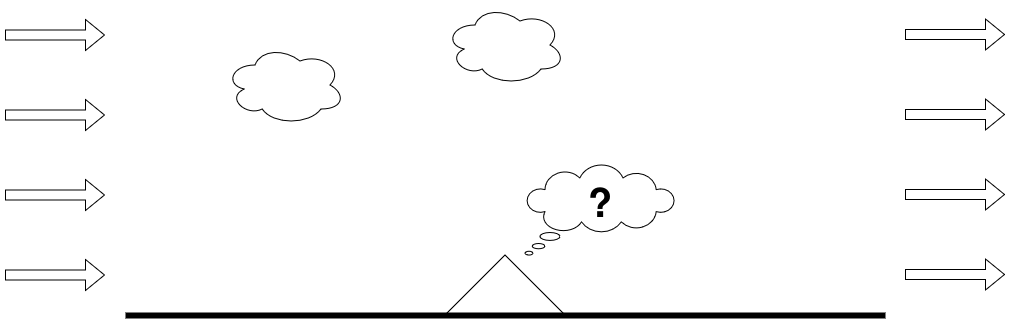

To generate the mesh we will use [HOHQMesh.jl](https://trixi-framework.github.io/HOHQMesh.jl), a Julia frontend to the Fortran-based *High Order Hex-Quad Mesher*.

The following Julia code is also available in `scripts/mountain_dome.jl`.

In [ ]:
using HOHQMesh

# plotting backend
using CairoMakie

project = newProject("Mountain", "output_mesh")  # project name, output folder

mountainHeight = 400      # height of montain 400 m
mountainHalfWidth = 1000  # half width of mountain 1 km
x_ll = -12000.0           # domain width 40 km
x_lr =  28000.0
width = x_lr - x_ll

# lower left and right y-values according to parametrization
y_ll = mountainHeight / ( 1 + (x_ll / mountainHalfWidth)^2 )
y_lr = mountainHeight / ( 1 + (x_lr / mountainHalfWidth)^2 )

# parametrized bottom curve, t ∈ [0,1]
xEqn = "x(t) = $x_ll + t * $width"
yEqn = "y(t) = $mountainHeight / ( 1 + (($x_ll + t * $width) / $mountainHalfWidth)^2 )"
zEqn = "z(t) = 0.0"
bottom = newParametricEquationCurve("bottom", xEqn, yEqn, zEqn)

# spline curve above
spline_data = [ [0.0   x_lr                 y_lr          0.0]
                [0.2   x_ll + 0.9 * width   0.4 * width   0.0]
                [0.8   x_ll + 0.1 * width   0.4 * width   0.0]
                [1.0   x_ll                 y_ll          0.0] ]

dome = newSplineCurve("dome", size(spline_data)[1], spline_data)

# use curves as outer boundary
for curve in [dome, bottom]
    addCurveToOuterBoundary!(project, curve)
end

# set the desired resolution in x and y direction
addBackgroundGrid!(project, [2000.0, 2000.0, 0.0])

# have a look
plotProject!(project, MODEL+GRID)

# set polynomial degree for curved boundaries
setPolynomialOrder!(project, 3)

# change output format to ABAQUS
setMeshFileFormat!(project, "ABAQUS")

# generate, will also update the plot to show the final mesh
generate_mesh(project)

<br/>

## **3. Run the simulation**

Next we will run [Trixi.jl](https://github.com/trixi-framework/Trixi.jl).
The following Julia code is also available in `scripts/mountain_gravity_wave.jl`.

In [ ]:
using Trixi
using OrdinaryDiffEq
using Plots
using LinearAlgebra

###############################################################################
# Physical parameters
###############################################################################
g::Float64 = 9.81           # constant gravitational potential
c_p::Float64 = 1004.0       # heat capacity at constant pressure (dry air)
c_v::Float64 = 717.0        # heat capacity at constant volume (dry air)
gamma::Float64 = c_p / c_v  # heat capacity ratio (dry air)
R::Float64 = c_p - c_v      # specific gas constant (dry air)
v1_0::Float64 = 10.0        # prescribed horizontal velocity
v2_0::Float64 = 0.0         # prescribed vertical velocity
        

###############################################################################
# Initial condition
###############################################################################
function initial_condition_nonhydrostatic(x, t, equations::CompressibleEulerEquations2D)

    p_0 = 100_000.0  # surface pressure
    theta_0 = 280.0  # surface potential temperature
    N = 0.01         # Väisälä frequency
  
    theta = theta_0 * exp(N^2 * x[2] / g)
    p = p_0 * (1 + g^2 / (c_p * theta_0 * N^2) * (exp(-x[2] * N^2 / g) - 1))^(c_p / R)
    rho = p / ((p / p_0)^(R / c_p) * R * theta)

    prim = SVector(rho, v1_0, v2_0, p)
    return prim2cons(prim, equations)
end


###############################################################################
# Source terms
###############################################################################
@inline function source_terms_geopotential(u, x, t, equations::CompressibleEulerEquations2D)
    rho, _, rho_v2, _ = u
    return SVector(zero(eltype(u)), zero(eltype(u)), -g * rho, -g * rho_v2)
end


###############################################################################
# Mesh
###############################################################################
file_path = "./output_mesh/Mountain.inp"
mesh = T8codeMesh(Trixi.AbaqusFile{2}(file_path); initial_refinement_level=1)


###############################################################################
# Solver
###############################################################################
polydeg = 3
basis = LobattoLegendreBasis(polydeg)

surface_flux = flux_lax_friedrichs

solver = DGSEM(basis, surface_flux)


# STEP 1: run the simulation
tspan = (0.0, 10.0)
show_mesh = true
solution_variables = cons2prim
variable_names = ["rho", "p", "v2"]


# STEP 1.5: compute and plot the temperature
#@inline function cons2temp(u, equations::CompressibleEulerEquations2D)
#  rho, v1, v2, p = cons2prim(u, equations)
#  T = p / (rho * R)
#  p_0 = 100_000.0  # surface pressure
#  Tpot = T * (p_0 / p)^(R / c_p)
#  return SVector(rho, p, T, Tpot)
#end

#Trixi.varnames(::typeof(cons2temp), ::CompressibleEulerEquations2D) = ("rho", "p", "T", "Tpot")

#solution_variables = cons2temp
#variable_names = ["rho", "T", "Tpot"]


# STEP 2: increase the final simulation time
#tspan = (0.0, 3500.0)
#show_mesh = false
#solution_variables = cons2prim
#variable_names=["v2"]


# STEP 3: use DGSEM with flux differencing
# Some theory: https://trixi-framework.github.io/Trixi.jl/stable/tutorials/DGSEM_FluxDiff/
#surface_flux = flux_hllc
#volume_flux = flux_chandrashekar
#volume_integral = VolumeIntegralFluxDifferencing(volume_flux)
#solver = DGSEM(basis, surface_flux, volume_integral)

# STEP 4: change surface flux to FluxLMARS, watch the final timing output!
#surface_flux = FluxLMARS(340.0)
#solver = DGSEM(basis, surface_flux, volume_integral)


###############################################################################
# Semidiscretization of the compressible Euler equations
###############################################################################
equations = CompressibleEulerEquations2D(gamma)

initial_condition = initial_condition_nonhydrostatic

boundary_condition_uniform_flow = BoundaryConditionDirichlet(initial_condition)

boundary_conditions = Dict(
    :dome => boundary_condition_uniform_flow,
    :bottom => boundary_condition_slip_wall)
    

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver,
                                    source_terms=source_terms_geopotential,
                                    boundary_conditions=boundary_conditions)


###############################################################################
# ODE solvers, callbacks etc.
###############################################################################
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()

analysis_interval = 10000
analysis_callback = AnalysisCallback(semi, interval=analysis_interval)

alive_callback = AliveCallback(analysis_interval=analysis_interval)

stepsize_callback = StepsizeCallback(cfl=1.0)

# STEP 5: activate AMR
# remove "#=" and "=#" below, also uncomment "amr_callback"
#=
show_mesh = true

@inline function v2abs(u, equations::CompressibleEulerEquations2D)
    rho, _, rho_v2 = u
    return abs(rho_v2 / rho)
end

amr_indicator = IndicatorMax(semi, variable=v2abs)

amr_controller = ControllerThreeLevel(semi, amr_indicator,
                                      base_level=0,
                                      med_level=1, med_threshold=0.6,
                                      max_level=3, max_threshold=1.3)

amr_callback = AMRCallback(semi, amr_controller,
                           interval=1000,
                           adapt_initial_condition=true,
                           adapt_initial_condition_only_refine=false)
=#

visualization = VisualizationCallback(interval = 5000,
                                      show_mesh = show_mesh,
                                      solution_variables = solution_variables,
                                      variable_names = variable_names)

callbacks = CallbackSet(summary_callback,
                        analysis_callback,
                        alive_callback,
#                        amr_callback,
                        stepsize_callback,
                        visualization);


###############################################################################
# Run the simulation
###############################################################################
sol = solve(ode,
            SSPRK33(), # OrdinaryDiffEq.jl's integration method
            dt=1,      # initial time step, will be overwritten by the stepsize_callback
            save_everystep=false,
            callback=callbacks);

summary_callback() # print the timer summary